In [2]:
import os
import torch

from vit_models.model import ViTPose
from configs.ViTPose_coco import model_small as model_cfg

# Torch to ONNX

In [12]:
CKPT_PATH = "ckpts/vitpose-25-s.pth"
C, H, W = (3, 256, 192)

model = ViTPose(model_cfg)
ckpt = torch.load(CKPT_PATH, map_location='cpu')
model.load_state_dict(ckpt)
model.eval()

output_onnx = 'ckpts/vitpose-25-s.onnx'
input_names = ["input_0"]
output_names = ["output_0"]

device = next(model.parameters()).device
inputs = torch.randn(1, C, H, W).to(device)

dynamic_axes = {'input_0' : {0 : 'batch_size'},
                'output_0' : {0 : 'batch_size'}}

torch_out = torch.onnx.export(model, inputs, output_onnx, export_params=True, verbose=False,
                              input_names=input_names, output_names=output_names, 
                              opset_version=11, dynamic_axes = dynamic_axes)
print(f">>> Saved at: {os.path.abspath(output_onnx)}")

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

>>> Saved at: /Users/junkybyte/Documents/easy_ViTPose/easy_ViTPose/ckpts/vitpose-25-s.onnx


# Inference with ONNX

>>> Original image size: 798 X 720 (height X width)
>>> Resized image size: 256 X 192 (height X width)
>>> Scale change: 3.1171875, 3.75
>>> Output size: (1, 25, 64, 48) ---> 0.0390 sec. elapsed [ 25.6 fps]



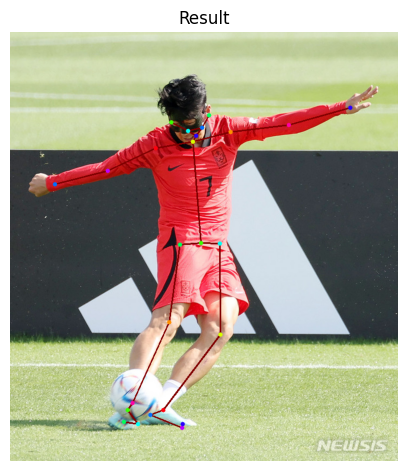

In [15]:
IMG_PATH = "examples/img1.jpg"

import onnx
import onnxruntime

import cv2
import numpy as np
import matplotlib.pyplot as plt


from time import time
from PIL import Image
from torchvision.transforms import transforms

from vit_utils.visualization import draw_points_and_skeleton, joints_dict
from vit_utils.dist_util import get_dist_info, init_dist
from vit_utils.top_down_eval import keypoints_from_heatmaps

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = onnxruntime.InferenceSession(output_onnx)

# Prepare input data
img = Image.open(IMG_PATH)

org_w, org_h = img.size
print(f">>> Original image size: {org_h} X {org_w} (height X width)")
print(f">>> Resized image size: {H} X {W} (height X width)")
print(f">>> Scale change: {org_h/H}, {org_w/W}")
img_tensor = transforms.Compose (
    [transforms.Resize((H, W)),
        transforms.ToTensor()]
)(img).unsqueeze(0).to(device)


# Feed to model
tic = time()
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_tensor)}
heatmaps = ort_session.run(None, ort_inputs)[0]
# heatmaps = vit_pose(img_tensor).detach().cpu().numpy() # N, 17, h/4, w/4
elapsed_time = time()-tic
print(f">>> Output size: {heatmaps.shape} ---> {elapsed_time:.4f} sec. elapsed [{elapsed_time**-1: .1f} fps]\n")    

points, prob = keypoints_from_heatmaps(heatmaps=heatmaps, center=np.array([[org_w//2, org_h//2]]), scale=np.array([[org_w, org_h]]),
                                        unbiased=True, use_udp=True)
points = np.concatenate([points[:, :, ::-1], prob], axis=2)

# Visualization 
for pid, point in enumerate(points):
    img = draw_points_and_skeleton(np.array(img).copy(), point, joints_dict()['coco']['skeleton'], person_index=pid,
                                    points_color_palette='gist_rainbow', skeleton_color_palette='jet',
                                    points_palette_samples=10, confidence_threshold=0.4)
    
    plt.figure(figsize=(5,10))
    plt.imshow(img)
    plt.title("Result")
    plt.axis('off')
    plt.show()
